<a href="https://colab.research.google.com/github/behrouzdarvishzad/behrouzdarvishzad/blob/main/Apple_stock_LSTM_%26_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import itertools
#import warnings
#warnings.filterwarnings("ignore")

import datetime

import torch
import torch.nn as nn

In [ ]:
import yfinance as yf

# Define the ticker symbol for the S&P 500 index
ticker_symbol = "AAPL"

# Define the desired date range for the historical data
start_date = "2018-06-26"
end_date = "2023-06-26"

# Download the historical data using yfinance
raw_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(raw_data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-06-26   45.747501   46.632500   45.634998   46.107498   44.063801   
2018-06-27   46.307499   46.820000   46.007500   46.040001   43.999287   
2018-06-28   46.025002   46.552502   45.950001   46.375000   44.319443   
2018-06-29   46.572498   46.797501   45.727501   46.277500   44.226265   
2018-07-02   45.955002   46.825001   45.855000   46.794998   44.720825   
...                ...         ...         ...         ...         ...   
2023-06-16  186.729996  186.990005  184.270004  184.919998  184.919998   
2023-06-20  184.410004  186.100006  184.410004  185.009995  185.009995   
2023-06-21  184.899994  185.410004  182.589996  183.960007  183.960007   
2023-06-22  183.740005  187.050003  183.669998  187.000000  187.000000   
2023-06-23  185.550003  187.559998  185.009

In [ ]:
raw_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,109.006194,110.324197,107.782436,109.117776,107.740450,1.102465e+08
std,46.081834,46.624572,45.571873,46.127342,46.428514,5.471994e+07
min,35.994999,36.430000,35.500000,35.547501,34.209965,3.519590e+07
25%,56.557499,57.064999,56.005001,56.602501,54.531590,7.477040e+07
50%,123.160004,124.639999,121.199997,122.940002,121.266876,9.562320e+07
75%,148.580002,150.009995,147.160004,148.789993,147.679947,1.295540e+08
max,186.729996,187.559998,185.009995,187.000000,187.000000,4.265100e+08


In [ ]:
raw_data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
raw_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
raw_data.reset_index(inplace=True)
raw_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-06-26,45.747501,46.632500,45.634998,46.107498,44.063801,98276800
1,2018-06-27,46.307499,46.820000,46.007500,46.040001,43.999287,101141200
2,2018-06-28,46.025002,46.552502,45.950001,46.375000,44.319443,69460800
3,2018-06-29,46.572498,46.797501,45.727501,46.277500,44.226265,90950800
4,2018-07-02,45.955002,46.825001,45.855000,46.794998,44.720825,70925200


In [ ]:
raw_data['Date']

0      2018-06-26
1      2018-06-27
2      2018-06-28
3      2018-06-29
4      2018-07-02
          ...    
1252   2023-06-16
1253   2023-06-20
1254   2023-06-21
1255   2023-06-22
1256   2023-06-23
Name: Date, Length: 1257, dtype: datetime64[ns]

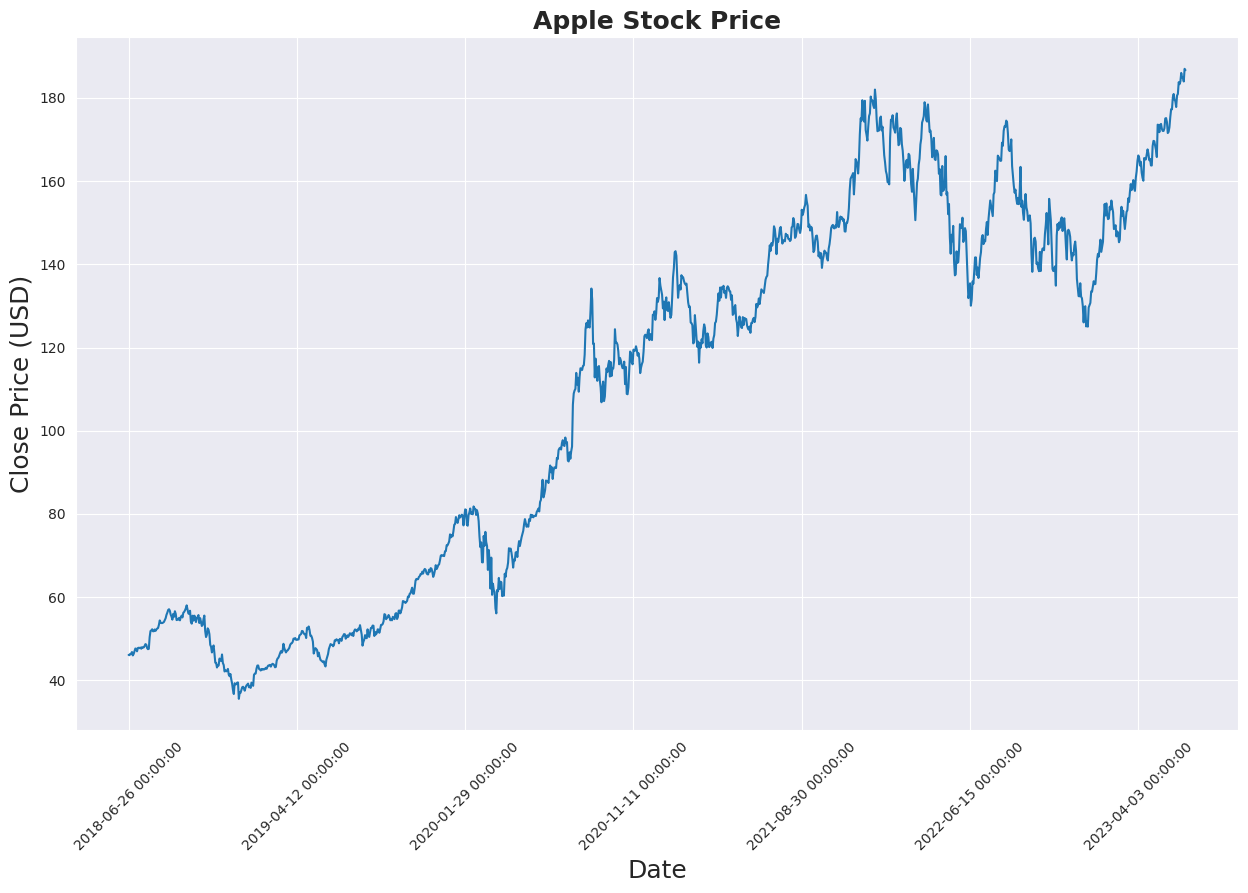

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(raw_data[['Close']])
plt.xticks(range(0,raw_data.shape[0],200),raw_data['Date'].loc[::200],rotation=45)
plt.title("Apple Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [ ]:
price = raw_data[['Close']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-51-77e3f41ac3d3>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
price['Close']

0      -0.860550
1      -0.861442
2      -0.857018
3      -0.858305
4      -0.851472
          ...   
1252    0.972533
1253    0.973721
1254    0.959855
1255    1.000000
1256    0.995774
Name: Close, Length: 1257, dtype: float64

In [ ]:
def split_data(stock, lookback):
  data_raw = stock.to_numpy()     # Create to numpy a data_raw
  data = []

  # Create all possible sequences of length seq_len
  for index in range(len(data_raw)-lookback):
    data.append(data_raw[index: index+lookback])

  data = np.array(data)
  test_set_size = int(np.round(0.2*data.shape[0]))
  train_set_size = data.shape[0] - test_set_size

  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]

  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]

  return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 20     # squence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (990, 19, 1)
y_train.shape =  (990, 1)
x_test.shape =  (247, 19, 1)
y_test.shape =  (247, 1)


In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1      # represents the size of the input at each time step, e.g. input of dimension 5 will look like this [1, 3, 8, 2, 3]
hidden_dim = 32    # represents the size of the hidden state and cell state at each time step
num_layers = 2     # the number of LSTM layers stacked on top of each other
output_dim = 1     # represents the size of the output at each time step
num_epochs = 100   # how many times will the input return the whole batch

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

## Define the Model

In [ ]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


## Train the model
Train the model over 100 epochs

In [ ]:
import time

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for epoch in range(num_epochs):
  y_train_pred = model(x_train)

  loss = criterion(y_train_pred, y_train_lstm)
  print('Epoch ', epoch, 'MSE: ', loss.item())
  hist[epoch] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

training_time = time.time() - start_time
print('Training time: {}'.format(training_time))

Epoch  0 MSE:  0.4051039516925812
Epoch  1 MSE:  0.3453933298587799
Epoch  2 MSE:  0.3025980591773987
Epoch  3 MSE:  0.27169302105903625
Epoch  4 MSE:  0.2317277044057846
Epoch  5 MSE:  0.14741250872612
Epoch  6 MSE:  0.07112763077020645
Epoch  7 MSE:  0.04570130631327629
Epoch  8 MSE:  0.10725819319486618
Epoch  9 MSE:  0.19482550024986267
Epoch  10 MSE:  0.06862097233533859
Epoch  11 MSE:  0.07967974990606308
Epoch  12 MSE:  0.0777037963271141
Epoch  13 MSE:  0.047459058463573456
Epoch  14 MSE:  0.021981626749038696
Epoch  15 MSE:  0.014289062470197678
Epoch  16 MSE:  0.01808796636760235
Epoch  17 MSE:  0.021806644275784492
Epoch  18 MSE:  0.020341480150818825
Epoch  19 MSE:  0.015433670952916145
Epoch  20 MSE:  0.012054892256855965
Epoch  21 MSE:  0.014285617507994175
Epoch  22 MSE:  0.01863623596727848
Epoch  23 MSE:  0.01952330209314823
Epoch  24 MSE:  0.018702473491430283
Epoch  25 MSE:  0.018680522218346596
Epoch  26 MSE:  0.018774807453155518
Epoch  27 MSE:  0.01760912127792835

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

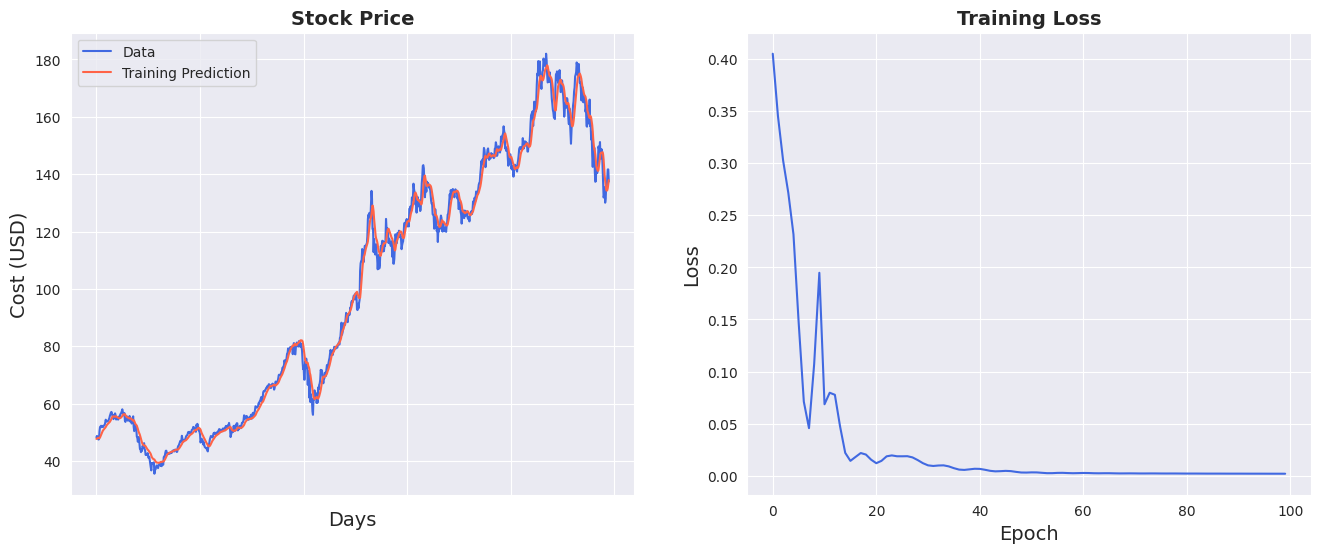

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x=original.index, y=original[0], label='Data', color='royalblue')
ax = sns.lineplot(x=predict.index, y=predict[0], label='Training Prediction', color='tomato')
ax.set_title('Stock Price', size=14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1,2,2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Make predictions
y_test_pred = model(x_test)

# Invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# Calculate root MSE
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f'Train score {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f'Test score {testScore:.2f} RMSE')

lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train score 3.34 RMSE
Test score 4.19 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2,
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

### GRU

[Gated Recurrent Unit (GRU)](https://blog.floydhub.com/gru-with-pytorch/) uses gating mechanisms to control and manage the flow of information between cells in the neural network.

<img src = "https://blog.floydhub.com/content/images/2019/07/image17-1.jpg" width = '420'>

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.44338950514793396
Epoch  1 MSE:  0.30089566111564636
Epoch  2 MSE:  0.22713221609592438
Epoch  3 MSE:  0.14419616758823395
Epoch  4 MSE:  0.041795432567596436
Epoch  5 MSE:  0.013966133818030357
Epoch  6 MSE:  0.08955123275518417
Epoch  7 MSE:  0.037737078964710236
Epoch  8 MSE:  0.0055600120685994625
Epoch  9 MSE:  0.01121753454208374
Epoch  10 MSE:  0.02704770676791668
Epoch  11 MSE:  0.03532358631491661
Epoch  12 MSE:  0.031230682507157326
Epoch  13 MSE:  0.019697630777955055
Epoch  14 MSE:  0.008194230496883392
Epoch  15 MSE:  0.0026271576061844826
Epoch  16 MSE:  0.005711050238460302
Epoch  17 MSE:  0.013539609499275684
Epoch  18 MSE:  0.016649845987558365
Epoch  19 MSE:  0.0127152930945158
Epoch  20 MSE:  0.006656766403466463
Epoch  21 MSE:  0.00273246131837368
Epoch  22 MSE:  0.0025922239292412996
Epoch  23 MSE:  0.00510952714830637
Epoch  24 MSE:  0.007602343335747719
Epoch  25 MSE:  0.00837956927716732
Epoch  26 MSE:  0.007437824737280607
Epoch  27 MSE:  0.005

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

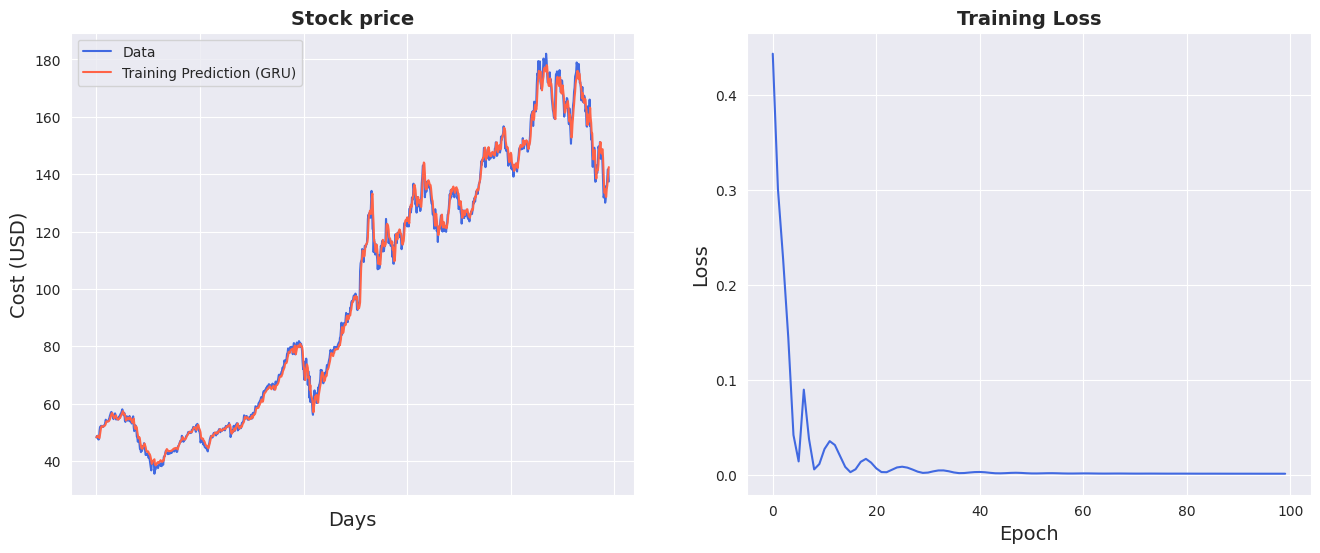

In [ ]:
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 2.39 RMSE
Test Score: 3.11 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
# The result does not work in colab. I run it in jupiter then send to colab.
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,3.338239,2.390696
Test RMSE,4.187194,3.112262
Train Time,15.267385,8.421440


GRU performance is better than LSTM reached a lower mean square error (in training, and most importantly, in the test set) and in speed.

In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
import chart_studio.plotly as py
import chart_studio

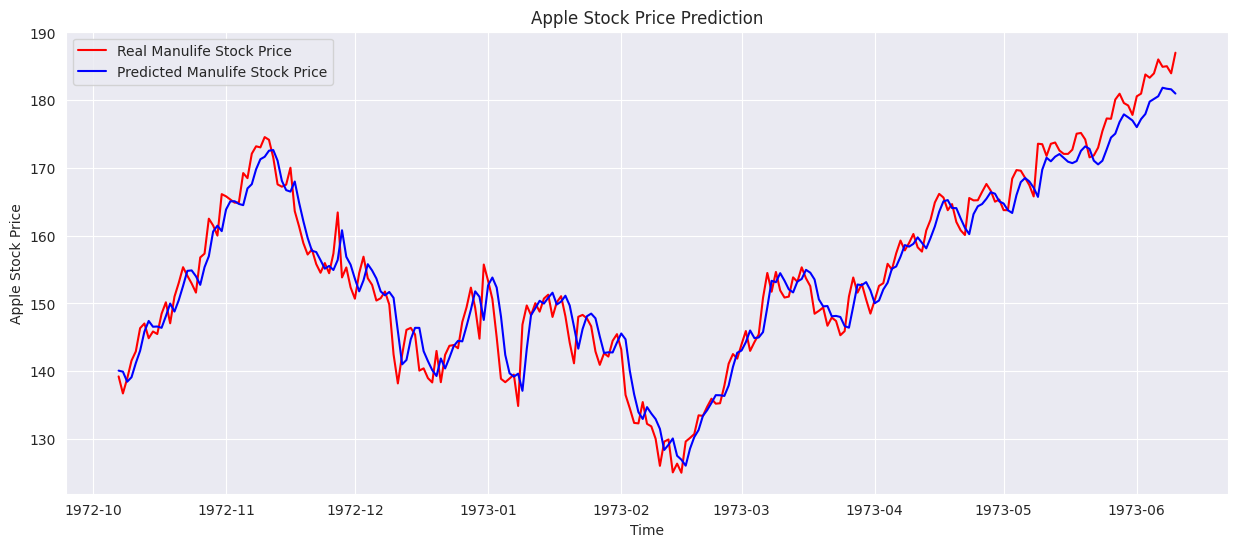

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(price[len(price)-len(y_test):].index, y_test, color = 'red', label = 'Real Apple Stock Price')
axes.plot(price[len(price)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.savefig('Apple_pred.png')
plt.show()



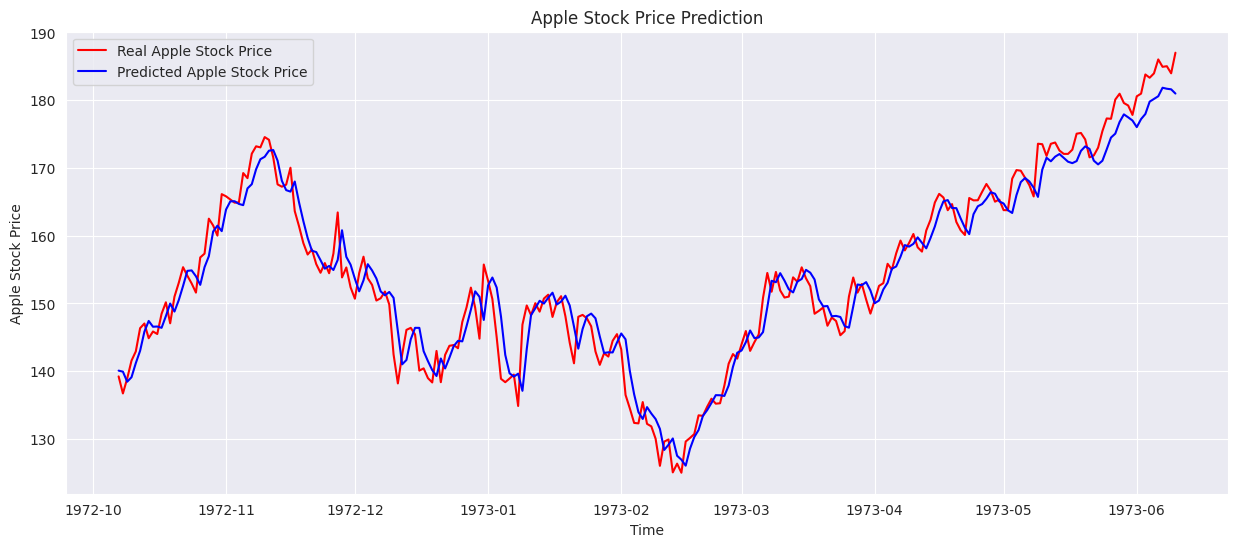

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(price.index[-len(y_test):], y_test, color='red', label='Real Apple Stock Price')
axes.plot(price.index[-len(y_test):], y_test_pred, color='blue', label='Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.savefig('Apple_pred.png')
plt.show()
